# Convolutional Neural Network to Classify Images
We build a convolutional Neural Network (CNN) to classify objects in images. The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) database is used for this purpose.

## 1. Load Dataset

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print('images:', x_train.shape[1:])
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

from collections import Counter
import numpy as np

#print Counter(list(np.vstack([y_train,y_test])[:,0])).items()
for key, val in Counter(list(np.vstack([y_train,y_test]).squeeze())).items():
    print("label: %d, size: %d" %(key, val))

images: (32, 32, 3)
50000 train samples
10000 test samples
label: 6, size: 6000
label: 9, size: 6000
label: 4, size: 6000
label: 1, size: 6000
label: 2, size: 6000
label: 7, size: 6000
label: 8, size: 6000
label: 3, size: 6000
label: 5, size: 6000
label: 0, size: 6000


The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

## 2. Visualization

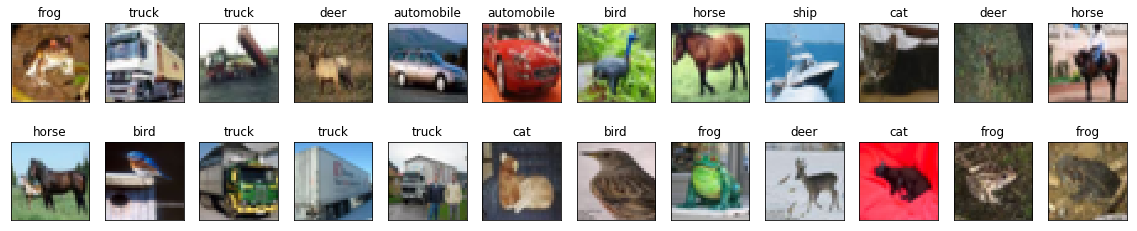

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

label ={'0':'airplane', '1':'automobile', '2':'bird', '3':'cat', '4':'deer', 
        '5':'dog', '6':'frog', '7':'horse', '8':'ship', '9':'truck'}

fig = plt.figure(figsize = (20,4) )
for i in range(24):
    ax = fig.add_subplot(2, 12, i+1, xticks = [], yticks = [])
    ax.imshow(x_train[i])
    ax.set_title(label["".join(map(str,y_train[i]))])    

## 3. Pre-processing
### A. Rescaling
We first rescale the images by dividing every pixel in every image by the number of color levels, i.e., 255. It follows that pixel values are now in [0,1] for every channel in every images.

In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### B. One-hot Encoding
We convert class vectors to binary class matrices.

In [6]:
from keras.utils import to_categorical

y_train = np.squeeze(to_categorical(y_train, num_classes=10))
y_test = np.squeeze(to_categorical(y_test, num_classes=10))

### C. Validation Set
We create a validation set by breaking the training set into two sets

In [7]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## 4. CNN
### A. Architecture
We consider a sequence of covolutional and max pooling layers. The convolutional layers expand the depth of the array from 3 to 128 using a 'relu' activation function while the max pooling layer squeezes out the spatial dimension by decreasing the features map from 32x32 to 2x2. Dropout layers are added to minimize overfitting (25% rate). The final feature map is flattened to a 2x2x128 vector. Finally, 2 fully connected layers. The last dense layer contains one node for each class of images, i.e., 10 nodes. We use a 'softmax' activation function to get probabilities.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4),
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

## B. Compilation

In [9]:
from keras.optimizers import rmsprop

opt = rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## C. Fit

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

checkpointer = ModelCheckpoint(filepath = 'cifar10.best.hdf5', verbose = 1, save_best_only = True)
checkimprovement = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10)
fit = History()

model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_valid,y_valid),
          callbacks = [checkpointer,checkimprovement,fit], verbose = 2, shuffle = True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.79438, saving model to cifar10.best.hdf5
 - 154s - loss: 2.4057 - acc: 0.2566 - val_loss: 1.7944 - val_acc: 0.3516
Epoch 2/100
Epoch 00002: val_loss improved from 1.79438 to 1.54556, saving model to cifar10.best.hdf5
 - 44s - loss: 1.7191 - acc: 0.3931 - val_loss: 1.5456 - val_acc: 0.4522
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 43s - loss: 1.5119 - acc: 0.4659 - val_loss: 1.6035 - val_acc: 0.4596
Epoch 4/100
Epoch 00004: val_loss improved from 1.54556 to 1.38138, saving model to cifar10.best.hdf5
 - 43s - loss: 1.3919 - acc: 0.5136 - val_loss: 1.3814 - val_acc: 0.5282
Epoch 5/100
Epoch 00005: val_loss improved from 1.38138 to 1.28070, saving model to cifar10.best.hdf5
 - 44s - loss: 1.3064 - acc: 0.5451 - val_loss: 1.2807 - val_acc: 0.5698
Epoch 6/100
Epoch 00006: val_loss improved from 1.28070 to 1.24034, saving model to cifar10.best.hdf5
 - 44s - loss: 1.2347 - acc: 

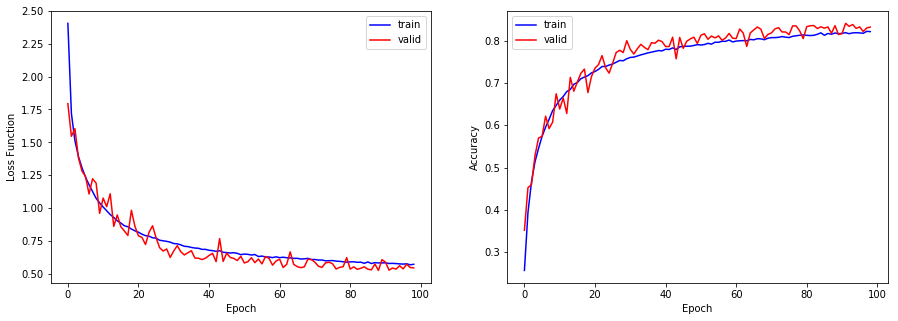

In [11]:
def history(fit):
    plt.figure(figsize = (15, 5) )
    
    plt.subplot(121)
    plt.plot(fit.history['loss'], color = 'blue', label = 'train')
    plt.plot(fit.history['val_loss'], color = 'red', label = 'valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    
    plt.subplot(122)
    plt.plot(fit.history['acc'], color = 'blue', label = 'train')
    plt.plot(fit.history['val_acc'], color = 'red', label = 'valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
history(fit)

In [12]:
# load the weights that yielded the best validation accuracy
model.load_weights('cifar10.best.hdf5')

## D. Accuracy

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print('Test accuracy: %.2f%%' % accuracy)

Test accuracy: 82.65%
